<a href="https://colab.research.google.com/github/Disha1203/Privacy-preserving-FL/blob/main/Central_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing all the required libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

# Importing and splitting the data into training and testing

In [ ]:
# Splitting the dataset into test and train according to patient_id
combined = pd.read_csv('/content/Dataset.csv')

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [ ]:
# importing the test and training data

df_train = pd.read_csv('data_part1.csv')
df_test = pd.read_csv('data_part2.csv')

# Exploratory data analysis

In [ ]:
print("Number of rows in the combined dataset:", len(combined))

Number of rows in the combined dataset: 724364


In [ ]:
# let's list down all the different columns

df_train.columns

Index(['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP',
       'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2',
       'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine',
       'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate',
       'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Patient_ID'],
      dtype='object')

In [ ]:
# list of all the unique patients
# total number of patients present in the dataset

patients = list(df_test['Patient_ID'].unique())
len(patients)

8281

In [ ]:
# Function to draw correlation heat map

def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# Percentage of null values present in all the parameters

null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
EtCO2,100.000000
TroponinI,99.869495
Bilirubin_direct,99.848158
Fibrinogen,99.195633
Bilirubin_total,98.744573
Alkalinephos,98.496713
AST,98.461977
Lactate,96.609602
SaO2,95.195385
PTT,95.096390


In [ ]:
# the features have been removed based on the number of null values and redundancy

# 'Unnamed: 0'-- this is the index column
# 'SBP' -- MAP is considered instead of SBP and DBP
# 'DBP' -- MAP is considered instead of SBP and DBP
# 'EtCO2' -- It is not readily. available and also not available in the dataset
# 'BaseExcess' -- It is an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'HCO3' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'pH' -- It is also an indicator of the health of kidney and pancreas but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PaCO2' -- It is an indicator of respiratory health of an individual, we are considering SaO2 and FiO2 which are more readily avaiilable
# 'Alkalinephos' -- It is an indicator of the health of the liver of an individual, but we are considering Bilirubin instead of this, as data of this is more scarce.
# 'Calcium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Magnesium' -- It is an indicator of metabolism and kidney health, but we are considering Lactate instead as it is more readily available
# 'Phosphate' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'Potassium' -- It is also an indicator of the health of kidney but is redundant here becuase a lot of different features for kidney are being considered here.
# 'PTT' -- It is used to check inflammation. We are using WBC counts instead as it is easy to obtain.
# 'Fibrinogen' -- It is used to check blood clotting ability. We are using Platelets instead, as it is easier to obtain.
# 'Unit1' -- Both the columns Unit1 and Unit2 have been merged to form a single column.
# 'Unit2' -- Both the columns Unit1 and Unit2 have been merged to form a single column.

columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

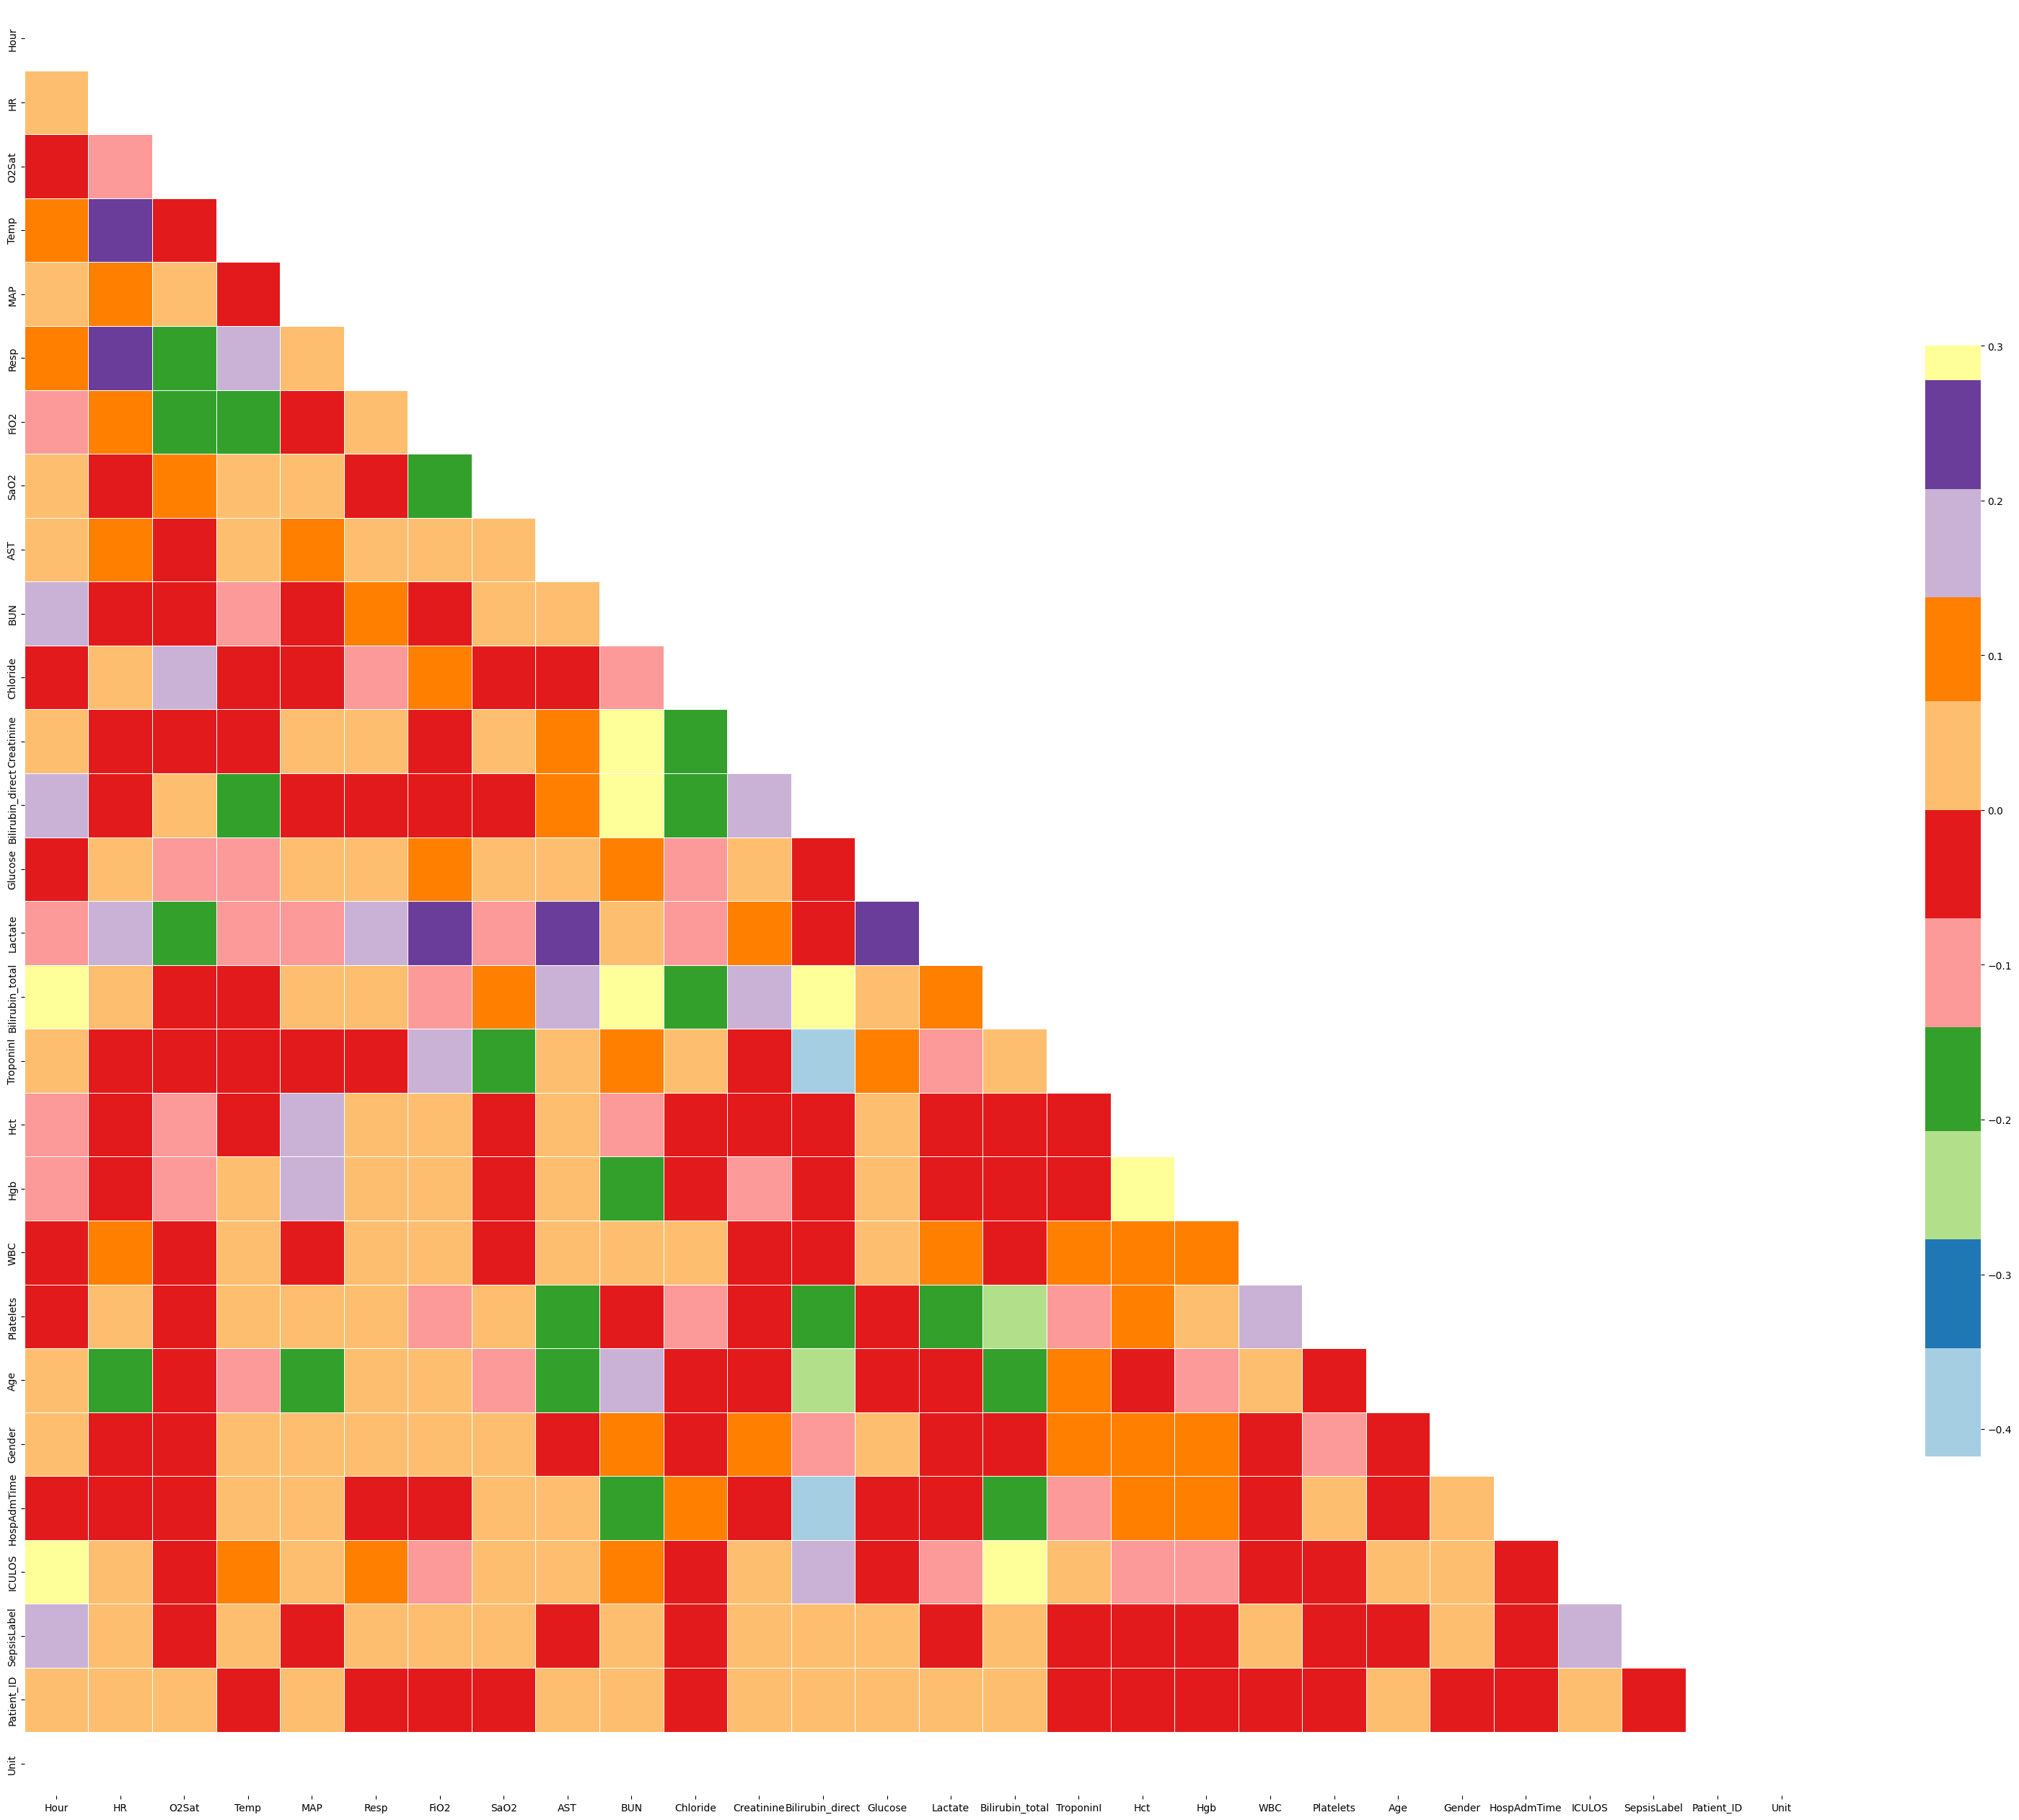

In [ ]:
# correlation matrix to check if there is high correlation between the remaining features

corr_matrix(df_train_mod)

As can be seen in this correlation heat map almost all of the feature do not have high correlation.

# Imputation

Since there are a lot of missing values in the dataset, therefore imputation was done to fill the missing values. While imputing, it is important to note that ***imputation should be done on per patient basis,*** otherwise the data from one patient will leak into the data of the other patient. Also another point that should be taken into consideration is that mean, median, mode can not directly be used to impute as it will result in uneven distribution of the parameters with respect to time.

In [ ]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [ ]:
# bfill and ffill for imputing

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

/tmp/ipython-input-468124072.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [ ]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp  FiO2  SaO2   AST  \
Patient_ID                                                                   
1.0        72964     0   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           72965     1   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           72966     2   89.0   99.0  36.11  86.00  22.0  0.28  88.0  16.0   
           72967     3   90.0   95.0  36.11  91.33  30.0  0.28  88.0  16.0   
           72968     4  103.0   88.5  36.11  91.33  24.5  0.28  88.0  16.0   

                   BUN  ...   Hgb  WBC  Platelets    Age  Gender  HospAdmTime  \
Patient_ID              ...                                                     
1.0        72964  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   
           72965  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   
           72966  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   
           72967  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   
           72968  14.0  ...  12.5  5.7      317.0  83.14     0.0        -0.03   

                  ICULOS  SepsisLabel  Patient_ID  Unit  
Patient_ID                                               
1.0        72964     1.0          0.0         1.0   NaN  
           72965     2.0          0.0         1.0   NaN  
           72966     3.0          0.0         1.0   NaN  
           72967     4.0          0.0         1.0   NaN  
           72968     5.0          0.0         1.0   NaN  

[5 rows x 28 columns]

In [ ]:
# Now let's check the remaining proportion of missing values

null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
TroponinI,97.229617
Bilirubin_direct,96.131736
Bilirubin_total,66.967788
AST,66.263903
SaO2,58.242546
Lactate,56.423661
Unit,49.014388
FiO2,36.681892
WBC,1.585911
Platelets,1.417694


'TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2', 'Unit', 'Patient_ID'  have more than 25 percent of null values and hence are dropped from the dataset.

In [ ]:
# dropping all the columns with null values more than 25% and patient_id

null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [ ]:
# onehot encoding the gender

one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)


## Gaussian Transformation and Standard Normalization

Generally models tend to give a better result for a normal ditribution. So in the below cells we explored different techniques to plot histograms and QQ plots of all the features and then we applied different transformations on it to see which were giving good results. The ones giving the beest results were then adopted in the dataframe.

In [ ]:
# function to draw histogram and QQ plot

def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [ ]:
# function to apply different transformations to make the plot gaussian

def try_gaussian(df, col):
  print('actual plot')
  diagnostic_plots(df,col)
  # this applies yeojohnson plot
  df['col_yj'], param = stats.yeojohnson(df[col])
  print('yeojohnson plot')
  diagnostic_plots(df, 'col_yj')
  # this applies exponential transformation
  df['col_1.5'] = df[col]**(1/1.5)
  print('**1/1.5 plot')
  diagnostic_plots(df, 'col_1.5')
  df['col_.5'] = df[col]**(.5)
  print('**.5 plot')
  # this applies inverse transformation
  diagnostic_plots(df, 'col_.5')
  df['col_rec'] = 1 / (df[col]+0.00001)
  diagnostic_plots(df, 'col_rec')
  # this applies logarithmic trasnformation
  df['col_log'] = np.log(df[col]+1)
  diagnostic_plots(df, 'col_log')


In [ ]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp   BUN  Chloride  \
Patient_ID                                                                 
1.0        72964     0   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           72965     1   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           72966     2   89.0   99.0  36.11  86.00  22.0  14.0      85.0   
           72967     3   90.0   95.0  36.11  91.33  30.0  14.0      85.0   
           72968     4  103.0   88.5  36.11  91.33  24.5  14.0      85.0   

                  Creatinine  Glucose   Hct   Hgb  WBC  Platelets    Age  \
Patient_ID                                                                 
1.0        72964         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           72965         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           72966         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           72967         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           72968         0.7    193.0  37.2  12.5  5.7      317.0  83.14   

                  HospAdmTime  ICULOS  SepsisLabel   0.0    1.0  
Patient_ID                                                       
1.0        72964        -0.03     1.0          0.0  True  False  
           72965        -0.03     2.0          0.0  True  False  
           72966        -0.03     3.0          0.0  True  False  
           72967        -0.03     4.0          0.0  True  False  
           72968        -0.03     5.0          0.0  True  False

In [ ]:
# by oserving different plots, it can be concluded that only log was somewhat effective and that too for MAP, BUN, Creatinine, Glucose, WBC & Plateletes
# therefore applying log transformations on the above columns

columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [ ]:
df_train_impute.head()

Hour     HR  O2Sat   Temp       MAP  Resp      BUN  \
Patient_ID                                                             
1.0        72964     0   97.0   95.0  36.11  4.335066  19.0  2.70805   
           72965     1   97.0   95.0  36.11  4.335066  19.0  2.70805   
           72966     2   89.0   99.0  36.11  4.465908  22.0  2.70805   
           72967     3   90.0   95.0  36.11  4.525369  30.0  2.70805   
           72968     4  103.0   88.5  36.11  4.525369  24.5  2.70805   

                  Chloride  Creatinine   Glucose   Hct   Hgb       WBC  \
Patient_ID                                                               
1.0        72964      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           72965      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           72966      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           72967      85.0    0.530628  5.267858  37.2  12.5  1.902108   
           72968      85.0    0.530628  5.267858  37.2  12.5  1.902108   

                  Platelets    Age  HospAdmTime  ICULOS  SepsisLabel   0.0  \
Patient_ID                                                                   
1.0        72964   5.762051  83.14        -0.03     1.0          0.0  True   
           72965   5.762051  83.14        -0.03     2.0          0.0  True   
           72966   5.762051  83.14        -0.03     3.0          0.0  True   
           72967   5.762051  83.14        -0.03     4.0          0.0  True   
           72968   5.762051  83.14        -0.03     5.0          0.0  True   

                    1.0  
Patient_ID               
1.0        72964  False  
           72965  False  
           72966  False  
           72967  False  
           72968  False

In [ ]:
# standard normalization

scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                 
1.0        72964     0  0.715923 -0.700667 -1.120248 -0.164374  0.047777   
           72965     1  0.715923 -0.700667 -1.120248 -0.164374  0.047777   
           72966     2  0.244941  0.570418 -1.120248  0.538969  0.604137   
           72967     3  0.303814 -0.700667 -1.120248  0.858603  2.087763   
           72968     4  1.069159 -2.766180 -1.120248  0.858603  1.067770   

                       BUN  Chloride  Creatinine   Glucose       Hct  \
Patient_ID                                                             
1.0        72964 -0.425199 -3.683766   -0.564299  1.447922  1.216157   
           72965 -0.425199 -3.683766   -0.564299  1.447922  1.216157   
           72966 -0.425199 -3.683766   -0.564299  1.447922  1.216157   
           72967 -0.425199 -3.683766   -0.564299  1.447922  1.216157   
           72968 -0.425199 -3.683766   -0.564299  1.447922  1.216157   

                       Hgb       WBC  Platelets    Age  HospAdmTime  ICULOS  \
Patient_ID                                                                    
1.0        72964  1.098159 -1.285243   1.062212  83.14        -0.03     1.0   
           72965  1.098159 -1.285243   1.062212  83.14        -0.03     2.0   
           72966  1.098159 -1.285243   1.062212  83.14        -0.03     3.0   
           72967  1.098159 -1.285243   1.062212  83.14        -0.03     4.0   
           72968  1.098159 -1.285243   1.062212  83.14        -0.03     5.0   

                  SepsisLabel   0.0    1.0  
Patient_ID                                  
1.0        72964          0.0  True  False  
           72965          0.0  True  False  
           72966          0.0  True  False  
           72967          0.0  True  False  
           72968          0.0  True  False

In [ ]:
df_train_impute = df_train_impute.dropna()

In [ ]:
null_values = df_train_impute.isnull().mean()*100
null_values

,0
Hour,0.0
HR,0.0
O2Sat,0.0
Temp,0.0
MAP,0.0
Resp,0.0
BUN,0.0
Chloride,0.0
Creatinine,0.0
Glucose,0.0


# Model Building

In [ ]:
# this function will transform the dataframe (for final testing) in the compatible
# format for the input of the model
# this will make it easier to get the dataframe ready in a single go for prediction

def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  # Convert column names to strings
  df.columns = df.columns.astype(str)
  return df

In [ ]:
# this fucntion calculates different evaluation parameters of a model

def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [ ]:
# checking the distribution of data points between the two classes

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 7885
while number of sepsis label 0 is 382848


So, this shows a clear imbalance between sepsis label 1 and label 0, to deal with this, we did undersampling.

In [ ]:
# Undersampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

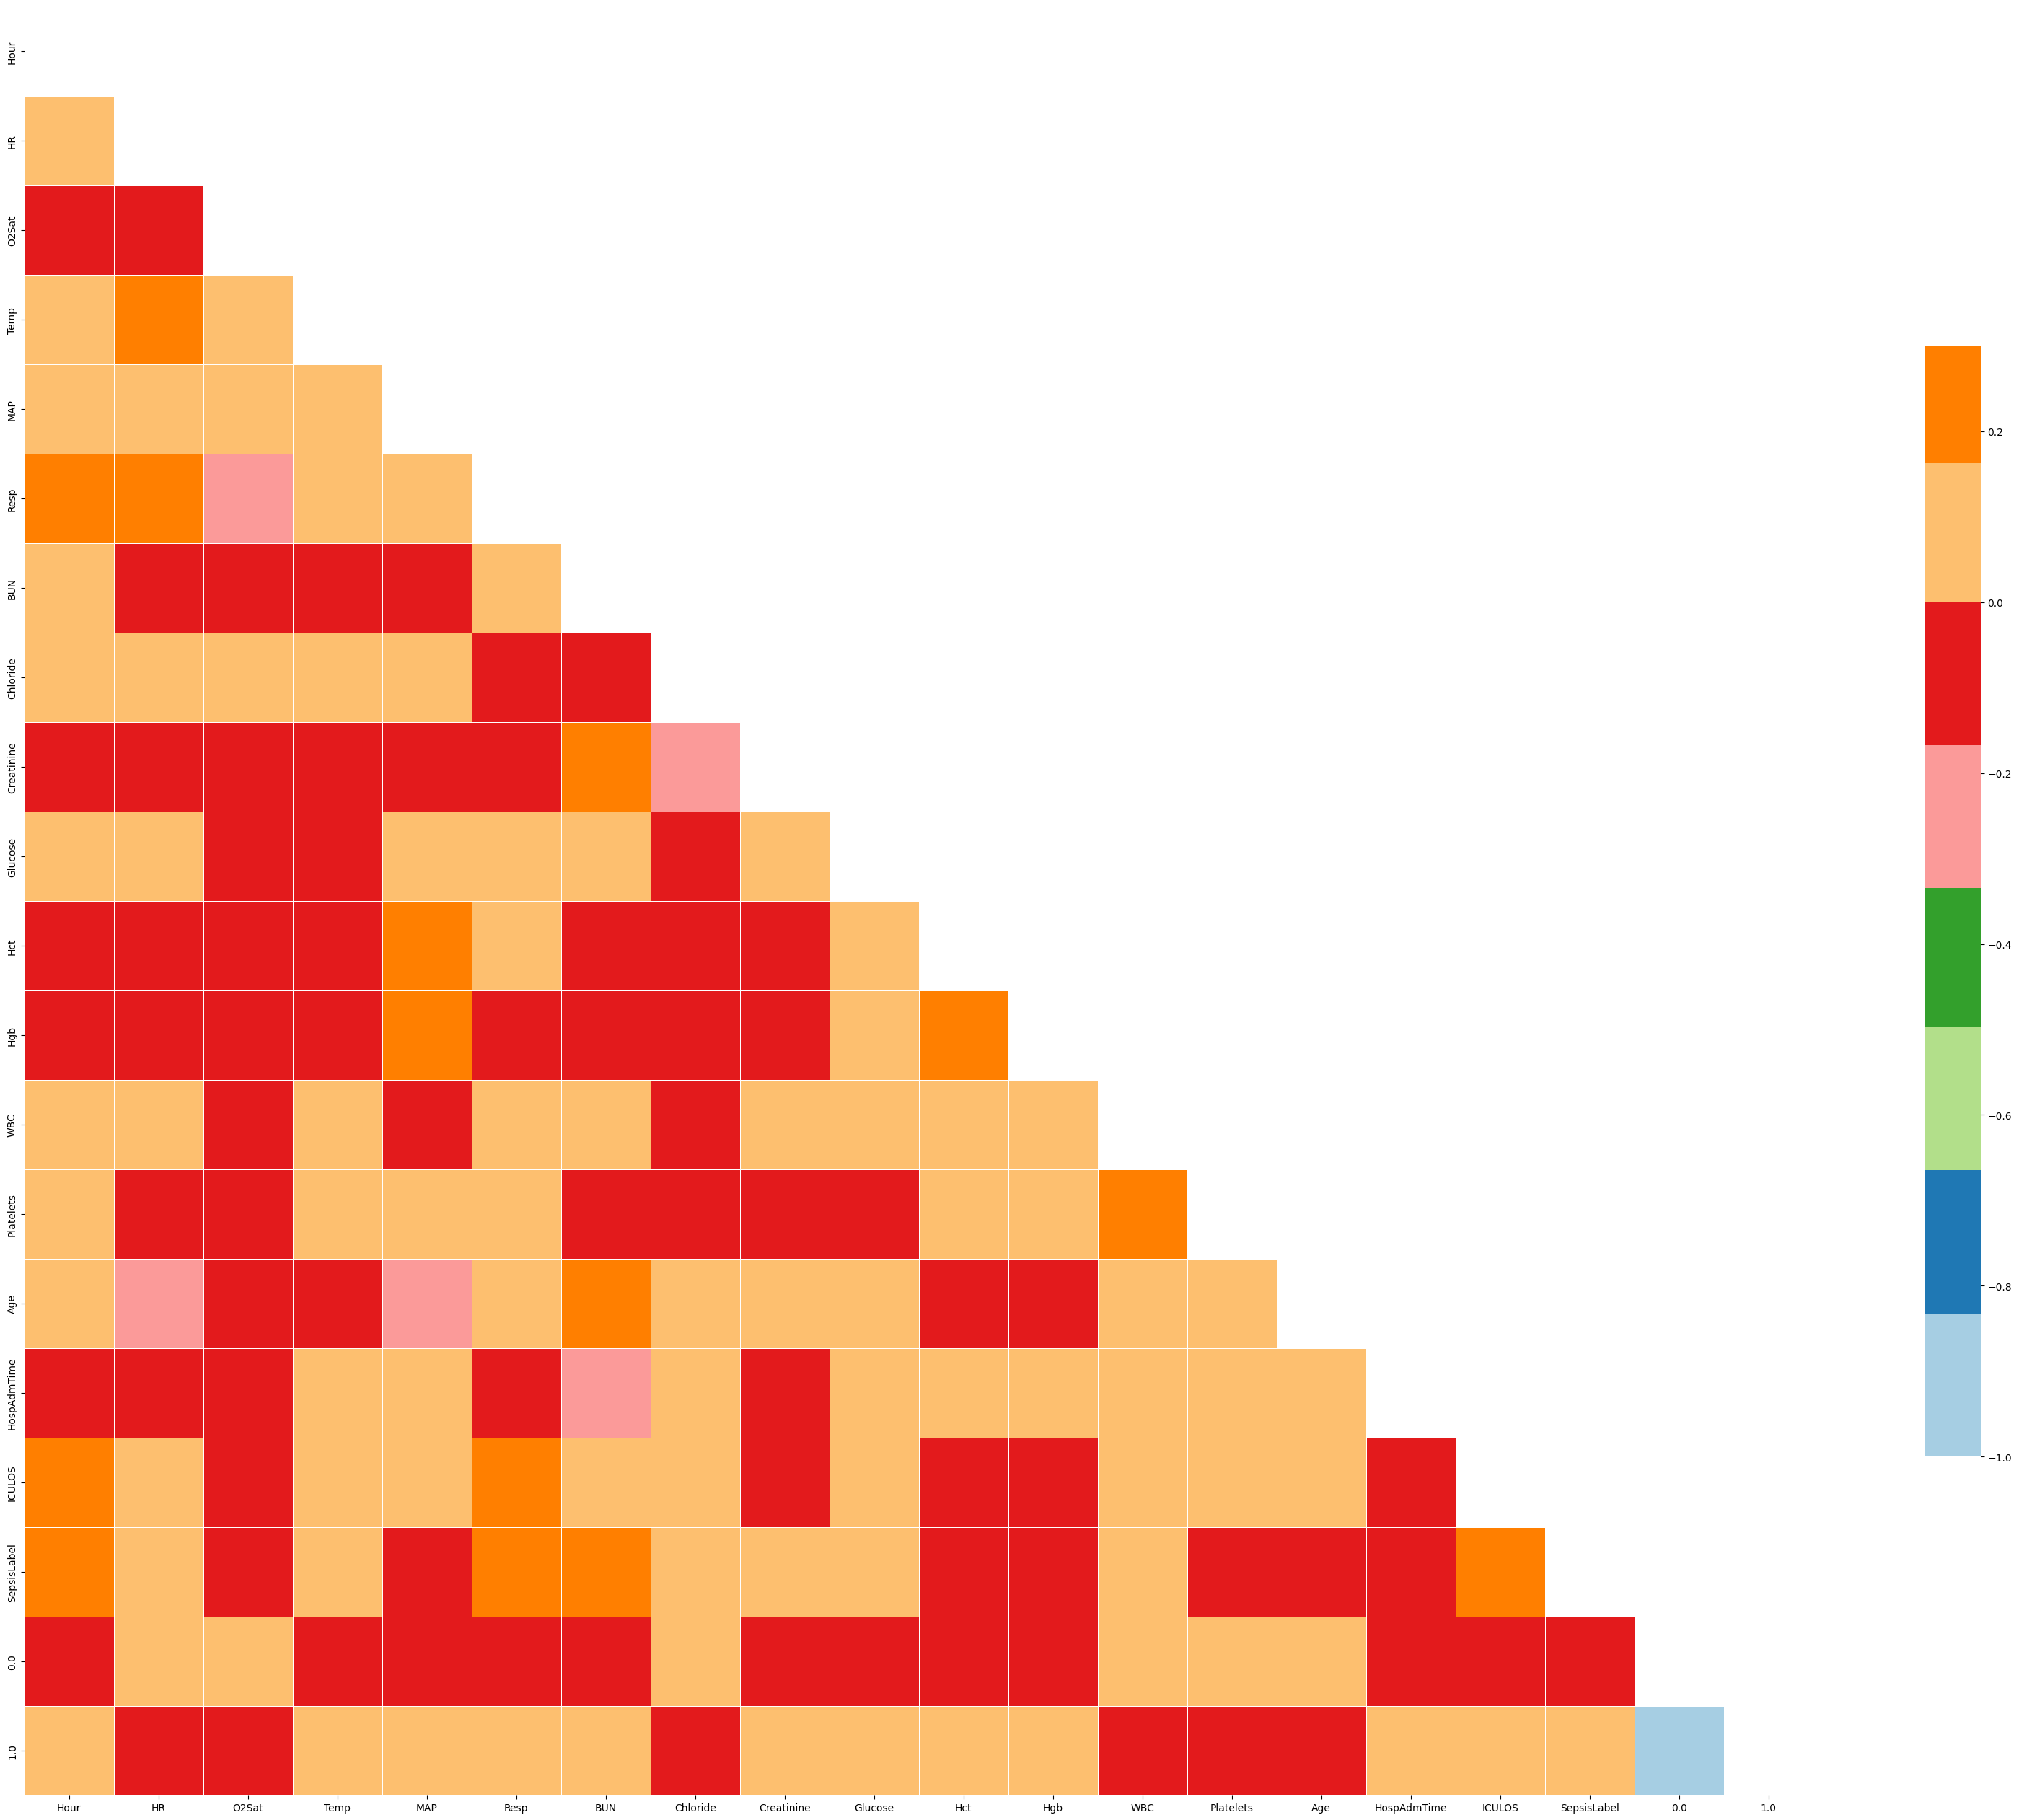

In [ ]:
corr_matrix(df_train_impute)

## Randomforest

In [ ]:
# train test split for the imputed output
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# random forest classifier
# random forest classifier was tested on different hyper parameters and it gave the best results with number of estimators as 300

# model = RandomForestClassifier(n_estimators=100, random_state=0)
# model = RandomForestClassifier(n_estimators=200, random_state=0)
model = RandomForestClassifier(n_estimators=300, random_state=0)

# Convert column names to strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

Accuracy: 0.9680828577467766
Precision: 0.9314079422382672
Recall: 0.9766561514195583
F1 Score: 0.9534955343393902
AUC-ROC: 0.9702098303188065
Mean Absolute Error: 0.03191714225322342
Root Mean Squared Error: 0.17865369364562103


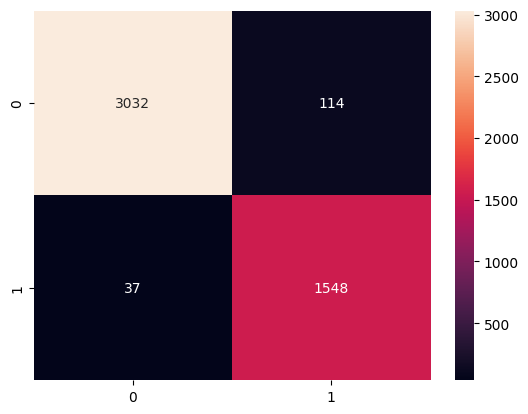

In [ ]:
evaluate_model(y_test,rcf_predictions)

Accuracy: 0.7600930035933207
Precision: 0.7188715953307393
Recall: 0.4662460567823344
F1 Score: 0.5656333716035209
AUC-ROC: 0.6871916870052803
Mean Absolute Error: 0.23990699640667934
Root Mean Squared Error: 0.4898030179640376


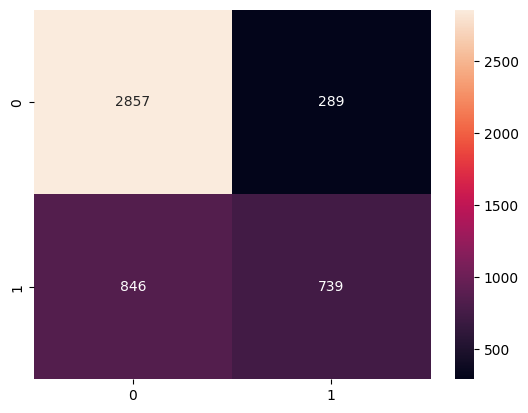

In [ ]:
# Naive Bayes Classifier
# NBC performed worse than random forest on each and every aspect of the evaluation metrics

from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
nbc_predictions = model.predict(X_test)
evaluate_model(y_test,nbc_predictions)

Accuracy: 0.8224476854787571
Precision: 0.7651245551601423
Recall: 0.6782334384858044
F1 Score: 0.7190635451505016
AUC-ROC: 0.7866691667953498
Mean Absolute Error: 0.17755231452124287
Root Mean Squared Error: 0.4213695699991195


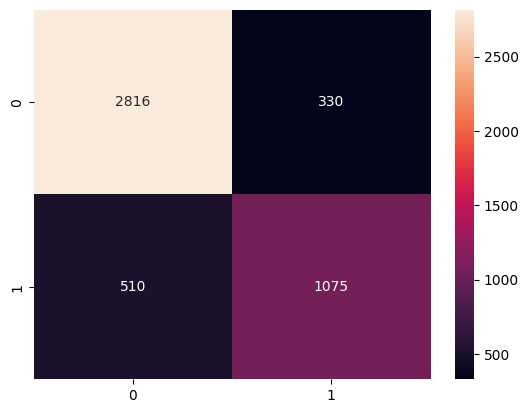

In [ ]:
# KNN Classifier
# KNN was tested on different values of k

from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier(n_neighbors=8)
# model = KNeighborsClassifier(n_neighbors=5)
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
knn_predictions = model.predict(X_test)
evaluate_model(y_test,knn_predictions)

Accuracy: 0.7577679137603044
Precision: 0.7508571428571429
Recall: 0.41451104100946373
F1 Score: 0.5341463414634147
AUC-ROC: 0.6726083494939245
Mean Absolute Error: 0.24223208623969564
Root Mean Squared Error: 0.49217078970586586


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


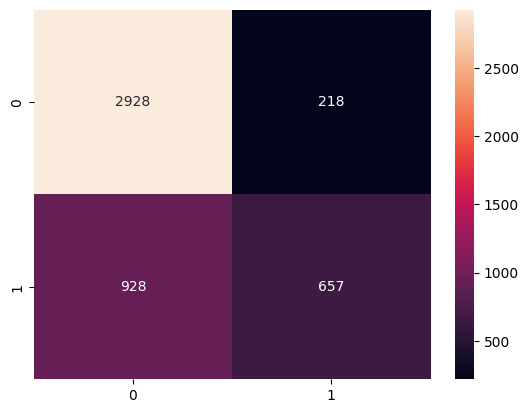

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
lr_predictions = model.predict(X_test)
evaluate_model(y_test,lr_predictions)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:49:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9038258296343268
Precision: 0.8717105263157895
Recall: 0.8359621451104101
F1 Score: 0.8534621578099839
AUC-ROC: 0.886989337018015
Mean Absolute Error: 0.09617417036567322
Root Mean Squared Error: 0.31011960654830134


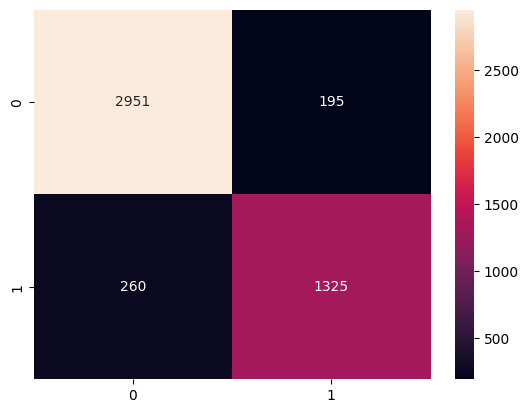

In [ ]:
# XGBoost
# XGBoost was run for different combinations of hyperparameters, but overall random forest classifier performed the best in terms of F1 score and other metrics

import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'binary:logistic'}  # error evaluation for binary classification
num_round = 100
bst = xgb.train(param, dtrain, num_round)
xgb_predictions = bst.predict(dtest)
prediction = []
for i in xgb_predictions:
  if i<0.5:
    prediction.append(0)
  else:
    prediction.append(1)
evaluate_model(y_test,prediction)

# Testing on the data of the other hospital

Epoch 1/10, Loss: 0.5106, Val Loss: 0.5322, Val Accuracy: 0.7495
Epoch 2/10, Loss: 0.5070, Val Loss: 0.5160, Val Accuracy: 0.7584
Epoch 3/10, Loss: 0.6722, Val Loss: 0.5319, Val Accuracy: 0.7628
Epoch 4/10, Loss: 0.6648, Val Loss: 0.5189, Val Accuracy: 0.7561
Epoch 5/10, Loss: 0.5753, Val Loss: 0.4963, Val Accuracy: 0.7671
Epoch 6/10, Loss: 0.4333, Val Loss: 0.4932, Val Accuracy: 0.7683
Epoch 7/10, Loss: 0.4362, Val Loss: 0.4875, Val Accuracy: 0.7745
Epoch 8/10, Loss: 0.4839, Val Loss: 0.4996, Val Accuracy: 0.7719
Epoch 9/10, Loss: 0.5637, Val Loss: 0.4817, Val Accuracy: 0.7776
Epoch 10/10, Loss: 0.4451, Val Loss: 0.4770, Val Accuracy: 0.7808

Validation Metrics:
Accuracy: 0.7808074402874656
Precision: 0.7366148531951641
Recall: 0.5381703470031546
F1 Score: 0.6219467736055414
AUC-ROC: 0.7206109204818698
Mean Absolute Error: 0.21919255971253435
Root Mean Squared Error: 0.4681800505281428


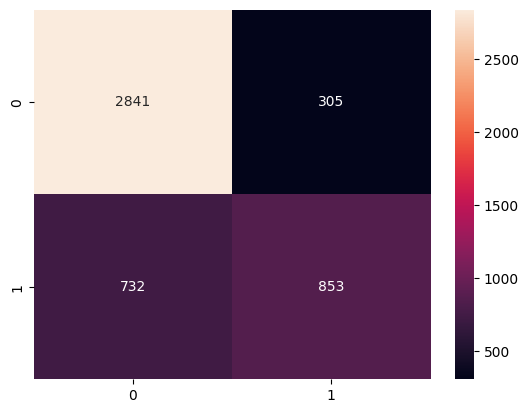

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_absolute_error, mean_squared_error

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Function to evaluate model
def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()


# Prepare data for MLP
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']

# Identify non-numeric columns and convert them
for col in X.columns:
    if X[col].dtype == 'object':
        try:
            X[col] = pd.to_numeric(X[col])
        except ValueError:
            # Handle columns that cannot be converted to numeric, perhaps drop or one-hot encode
            # For now, let's drop them and print a warning
            print(f"Warning: Dropping column '{col}' as it could not be converted to numeric.")
            X = X.drop(columns=[col])
    elif X[col].dtype == 'bool':
        X[col] = X[col].astype(float)


# Check if the DataFrame is empty after dropping non-numeric columns
if X.empty:
    print("Error: DataFrame X is empty after preprocessing. Cannot create tensors.")
else:
    # Convert pandas DataFrames to PyTorch tensors
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

    # Create DataLoader for training and validation sets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Initialize the MLP model, loss function, and optimizer
    input_size = X_train.shape[1]
    model = MLP(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_loss = 0
            correct = 0
            total = 0
            all_y_true = []
            all_y_pred = []
            for inputs, labels in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_y_true.extend(labels.numpy())
                all_y_pred.extend(predicted.numpy())

        accuracy = correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {accuracy:.4f}')

    # Evaluate on the full validation set and print metrics
    print("\nValidation Metrics:")
    evaluate_model(all_y_true, all_y_pred)

In [ ]:
print(X.dtypes)

Hour             int64
HR             float64
O2Sat          float64
Temp           float64
MAP            float64
Resp           float64
BUN            float64
Chloride       float64
Creatinine     float64
Glucose        float64
Hct            float64
Hgb            float64
WBC            float64
Platelets      float64
Age            float64
HospAdmTime    float64
ICULOS         float64
0.0            float64
1.0            float64
dtype: object
